# Lectura y preprocesamiento de las imagenes 

In [1]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from  tensorflow.keras import models, optimizers, regularizers
from tensorflow.keras.optimizers import Nadam
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2024-06-26 00:07:41.691149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 00:07:41.691280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 00:07:41.802502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Ruta del directorio que contiene las carpetas con imágenes
directorio_data = '/kaggle/input/corn-or-maize-leaf-disease-dataset/data'

# Listas para almacenar las imagenes (como matrices) y sus respectivas etiquetas
imagenes = []
etiquetas = []
tamanio_deseado = (150, 150) 

# Diccionario para almacenar una imagen de cada clase
muestra_por_clase = {}

# Iterar sobre las carpetas (etiquetas)
for etiqueta in os.listdir(directorio_data):
    # Construir la ruta completa de la carpeta de la etiqueta
    carpeta_etiqueta = os.path.join(directorio_data, etiqueta)
    
    # Verificar si es un directorio
    if os.path.isdir(carpeta_etiqueta):
        # Iterar sobre los archivos en la carpeta
        for nombre_archivo in os.listdir(carpeta_etiqueta):
            # Construir la ruta completa del archivo
            ruta_archivo = os.path.join(carpeta_etiqueta, nombre_archivo)
            
            # Leer la imagen con OpenCV y redimensionarla al tamaño deseado
            imagen = cv2.imread(ruta_archivo, cv2.IMREAD_COLOR)
            imagen = cv2.resize(imagen, tamanio_deseado)
            
            # Normalizar los valores de píxeles (escala de 0 a 1)
            imagen = imagen / 255.0
            
            # Agregar la imagen y la etiqueta a las listas
            imagenes.append(imagen)
            etiquetas.append(etiqueta)
            
            # Guardar una muestra de cada clase
            if etiqueta not in muestra_por_clase:
                muestra_por_clase[etiqueta] = imagen

# Convertir las listas a matrices numpy
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

# Convertir etiquetas de texto a valores numéricos usando LabelEncoder
label_encoder = LabelEncoder()
etiquetas_numericas = label_encoder.fit_transform(etiquetas)

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_numericas, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convertir las etiquetas a formato categórico
num_clases = len(np.unique(etiquetas_numericas))
y_train = to_categorical(y_train, num_clases)
y_valid = to_categorical(y_valid, num_clases)
y_test = to_categorical(y_test, num_clases)

# Convertir los conjuntos de datos a tipo float32
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

# Imprimir las formas de los conjuntos de entrenamiento, validación y prueba
print("Forma de X_train:", X_train.shape)
print("Forma de X_valid:", X_valid.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_valid:", y_valid.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (3015, 150, 150, 3)
Forma de X_valid: (335, 150, 150, 3)
Forma de X_test: (838, 150, 150, 3)
Forma de y_train: (3015, 4)
Forma de y_valid: (335, 4)
Forma de y_test: (838, 4)


# Transfer Learning con ResNet50

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congelar los pesos de la base

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model

model_resnet50 = create_resnet50_model((150, 150, 3), num_clases)
model_resnet50.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# Compilación del modelo
model_resnet50.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('mi_mejor_modelo001.keras', verbose=1, save_best_only=True, monitor='val_accuracy')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Entrenamiento con data augmentation
hist = model_resnet50.fit(datagen.flow(X_train, y_train, batch_size=32),
                 callbacks=[checkpoint],
                 steps_per_epoch=len(X_train) // 32, 
                 epochs=50,
                 verbose=2,
                 validation_data=(X_valid, y_valid))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1719363613.507916     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719363633.667302     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.31045, saving model to mi_mejor_modelo001.keras
94/94 - 36s - 379ms/step - accuracy: 0.6544 - loss: 0.8729 - val_accuracy: 0.3104 - val_loss: 1.3731
Epoch 2/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.31045
94/94 - 0s - 4ms/step - accuracy: 0.7188 - loss: 0.6602 - val_accuracy: 0.3104 - val_loss: 1.3683
Epoch 3/50

Epoch 3: val_accuracy improved from 0.31045 to 0.31642, saving model to mi_mejor_modelo001.keras
94/94 - 15s - 160ms/step - accuracy: 0.7378 - loss: 0.7051 - val_accuracy: 0.3164 - val_loss: 1.4401
Epoch 4/50

Epoch 4: val_accuracy improved from 0.31642 to 0.37910, saving model to mi_mejor_modelo001.keras
94/94 - 1s - 11ms/step - accuracy: 0.7812 - loss: 0.6733 - val_accuracy: 0.3791 - val_loss: 1.3299
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.37910
94/94 - 15s - 154ms/step - accuracy: 0.7549 - loss: 0.6629 - val_accuracy: 0.3433 - val_loss: 1.3204
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.37910
94/94 - 0s - 4ms/step - accuracy: 0.6875 - loss: 0.8881 - val_accuracy: 0.3403 - val_loss: 1.3686
Epoch 7/50

Epoch 7: val_accuracy improved from 0.37910 to 0.53731, saving model to mi_mejor_modelo001.kera

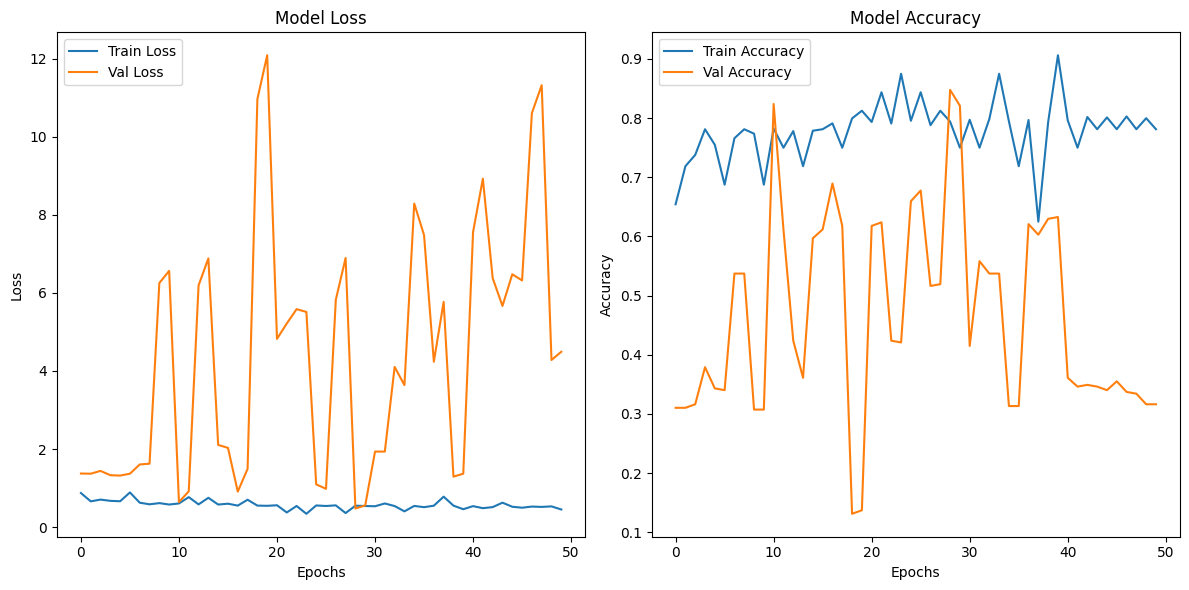

In [18]:
# Crea una figura con 2 subtramas
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Imprimir el loss
ax[0].plot(hist.history['loss'], label='Train Loss')
ax[0].plot(hist.history['val_loss'], label='Val Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Imprimir el accuracy
ax[1].plot(hist.history['accuracy'], label='Train Accuracy')
ax[1].plot(hist.history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [19]:
model2_resnet50 = model_resnet50
model2_resnet50.load_weights('./mi_mejor_modelo001.keras')
model2_resnet50.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8050 - loss: 0.5746


[0.6057624816894531, 0.800715982913971]

# Transfer Learning con DenseNet

In [20]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_densenet_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congelar los pesos de la base

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model

model_densenet = create_densenet_model((150, 150, 3), num_clases)
model_densenet.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [21]:
# Compilación del modelo
model_densenet.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('mi_mejor_modelo002.keras', verbose=1, save_best_only=True, monitor='val_accuracy')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Entrenamiento con Data augmentation
hist_densenet = model_densenet.fit(datagen.flow(X_train, y_train, batch_size=32),
                 callbacks=[checkpoint],
                 steps_per_epoch=len(X_train) // 32, 
                 epochs=50,
                 verbose=2,
                 validation_data=(X_valid, y_valid))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.89254, saving model to mi_mejor_modelo002.keras
94/94 - 80s - 848ms/step - accuracy: 0.7992 - loss: 0.5882 - val_accuracy: 0.8925 - val_loss: 0.3037
Epoch 2/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.89254 to 0.89552, saving model to mi_mejor_modelo002.keras
94/94 - 2s - 19ms/step - accuracy: 0.7500 - loss: 0.7580 - val_accuracy: 0.8955 - val_loss: 0.3015
Epoch 3/50

Epoch 3: val_accuracy improved from 0.89552 to 0.90149, saving model to mi_mejor_modelo002.keras
94/94 - 15s - 164ms/step - accuracy: 0.8696 - loss: 0.3497 - val_accuracy: 0.9015 - val_loss: 0.2745
Epoch 4/50

Epoch 4: val_accuracy improved from 0.90149 to 0.90448, saving model to mi_mejor_modelo002.keras
94/94 - 1s - 14ms/step - accuracy: 0.8750 - loss: 0.3367 - val_accuracy: 0.9045 - val_loss: 0.2760
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.90448
94/94 - 14s - 153ms/step - accuracy: 0.8870 - loss: 0.2993 - val_accuracy: 0.8896 - val_loss: 0.2841
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.90448
94/94 - 0s - 4ms/step - accuracy: 0.9688 - loss: 0.1289 - val_accuracy: 0.8925 - val_loss: 0.2831
Epoch 7/50

Epoch 7: val_accuracy did not improve from 0.904

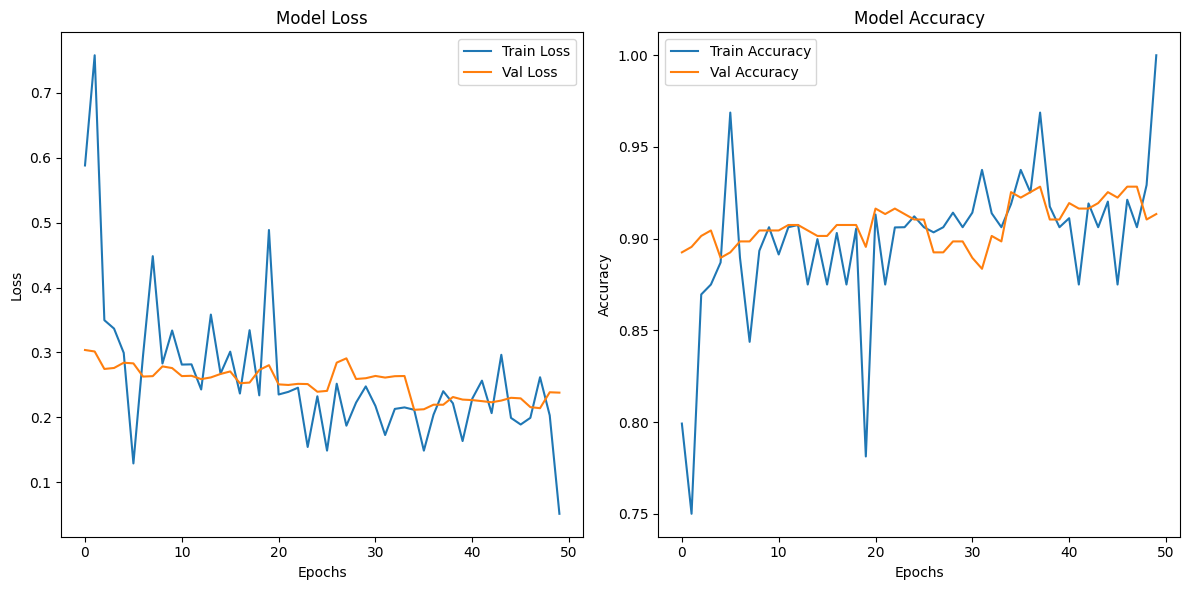

In [22]:
# Crea figura con 2 subtramas
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Imprimir el loss
ax[0].plot(hist_densenet.history['loss'], label='Train Loss')
ax[0].plot(hist_densenet.history['val_loss'], label='Val Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Imprimir el accuracy
ax[1].plot(hist_densenet.history['accuracy'], label='Train Accuracy')
ax[1].plot(hist_densenet.history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [23]:
model2_densenet = model_densenet
model2_densenet.load_weights('./mi_mejor_modelo002.keras')
model2_densenet.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.9353 - loss: 0.1987


[0.19604089856147766, 0.9343675374984741]

# Transfer Learning con MobileNet

In [26]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congelar los pesos de la base

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model

model_mobilnet = create_mobilenet_model((150, 150, 3), num_clases)
model_mobilnet.summary()


/tmp/ipykernel_34/1626447964.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [27]:
# Compilación del modelo
model_mobilnet.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('mi_mejor_modelo003.keras', verbose=1, save_best_only=True, monitor='val_accuracy')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Entrenamiento con data augmentation
hist_mobilnet = model_mobilnet.fit(datagen.flow(X_train, y_train, batch_size=32),
                 callbacks=[checkpoint],
                 steps_per_epoch=len(X_train) // 32, 
                 epochs=50,
                 verbose=2,
                 validation_data=(X_valid, y_valid))

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.90448, saving model to mi_mejor_modelo003.keras
94/94 - 29s - 309ms/step - accuracy: 0.8277 - loss: 0.5261 - val_accuracy: 0.9045 - val_loss: 0.2724
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.90448
94/94 - 0s - 2ms/step - accuracy: 0.9375 - loss: 0.2040 - val_accuracy: 0.9015 - val_loss: 0.2711
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.90448
94/94 - 14s - 148ms/step - accuracy: 0.8813 - loss: 0.3481 - val_accuracy: 0.8716 - val_loss: 0.3759
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.90448
94/94 - 0s - 2ms/step - accuracy: 0.8125 - loss: 0.5496 - val_accuracy: 0.8746 - val_loss: 0.3726
Epoch 5/50

Epoch 5: val_accuracy improved from 0.90448 to 0.91343, saving model to mi_mejor_modelo003.keras
94/94 - 14s - 150ms/step - accuracy: 0.8877 - loss: 0.2968 - val_accuracy: 0.9134 - val_loss: 0.2760
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.91343
94/94 - 0s - 2ms/step - accuracy: 

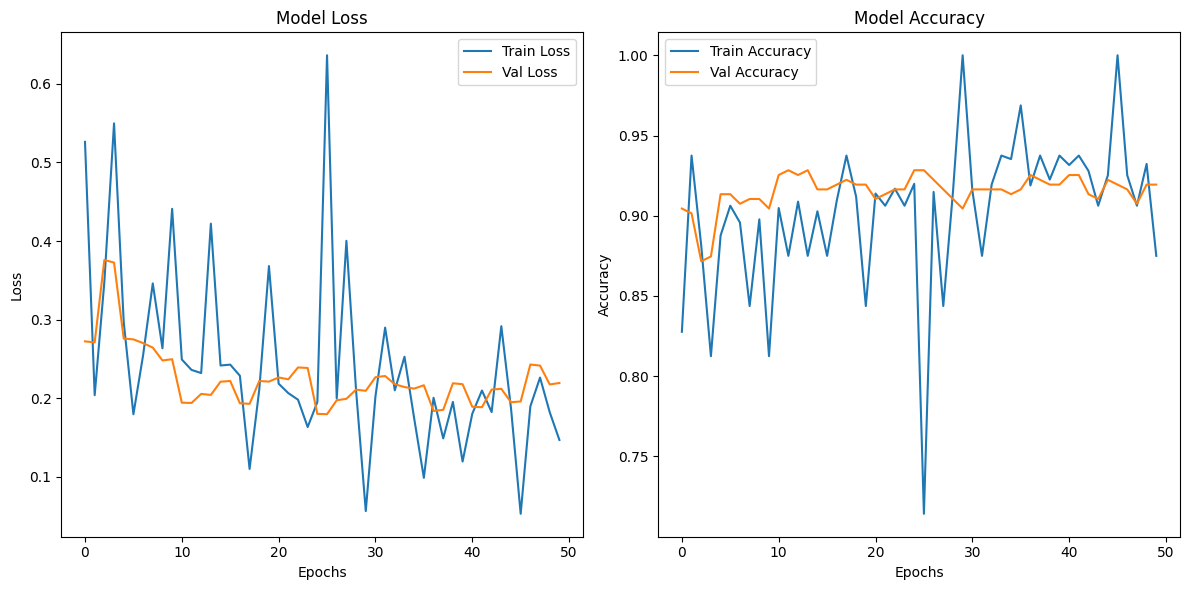

In [28]:
# Crea figura con 2 subtramas
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Imprimir el loss
ax[0].plot(hist_mobilnet.history['loss'], label='Train Loss')
ax[0].plot(hist_mobilnet.history['val_loss'], label='Val Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Imprimir el accuracy
ax[1].plot(hist_mobilnet.history['accuracy'], label='Train Accuracy')
ax[1].plot(hist_mobilnet.history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [29]:
model2_mobilnet = model_mobilnet
model2_mobilnet.load_weights('./mi_mejor_modelo003.keras')
model2_mobilnet.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9215 - loss: 0.2308


[0.2328677922487259, 0.915274441242218]

## Conclusiones generales

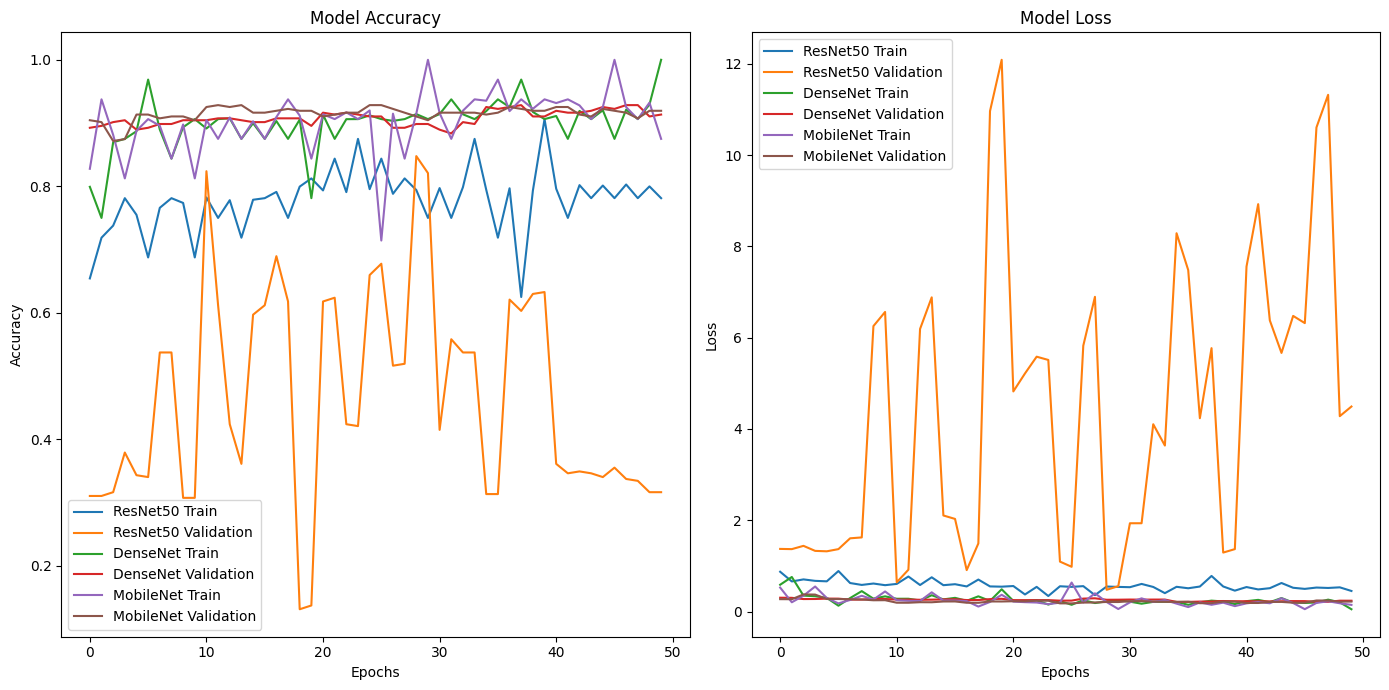

In [30]:
# Plotting accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.plot(hist.history['accuracy'], label='ResNet50 Train')
ax1.plot(hist.history['val_accuracy'], label='ResNet50 Validation')
ax1.plot(hist_densenet.history['accuracy'], label='DenseNet Train')
ax1.plot(hist_densenet.history['val_accuracy'], label='DenseNet Validation')
ax1.plot(hist_mobilnet.history['accuracy'], label='MobileNet Train')
ax1.plot(hist_mobilnet.history['val_accuracy'], label='MobileNet Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting loss
ax2.plot(hist.history['loss'], label='ResNet50 Train')
ax2.plot(hist.history['val_loss'], label='ResNet50 Validation')
ax2.plot(hist_densenet.history['loss'], label='DenseNet Train')
ax2.plot(hist_densenet.history['val_loss'], label='DenseNet Validation')
ax2.plot(hist_mobilnet.history['loss'], label='MobileNet Train')
ax2.plot(hist_mobilnet.history['val_loss'], label='MobileNet Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Probando el Modelo con 1 Imagen

In [8]:
# Cargar la imagen
imagen_a_analizar = cv2.imread('/kaggle/input/propio/Prueba03.jpg', cv2.IMREAD_COLOR)
imagen_a_analizar = cv2.resize(imagen_a_analizar, (150, 150))
imagen_a_analizar = imagen_a_analizar / 255.0
imagen_a_analizar = np.expand_dims(imagen_a_analizar, axis=0)  # Agregar la dimensión del lote

# Realizar la predicción
predicciones = model2.predict(imagen_a_analizar)

# Obtener la clase con la probabilidad más alta
indice_clase_predicha = np.argmax(predicciones)

# Obtener el nombre de la clase
nombre_clase_predicha = label_encoder.inverse_transform([indice_clase_predicha])[0]

# Imprimir el nombre de la clase predicha
print("Clase predicha:", nombre_clase_predicha)
print("Prueba hecha con imagenes de internet aleatoriamente")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Clase predicha: Blight
Prueba hecha con imagenes de internet aleatoriamente


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

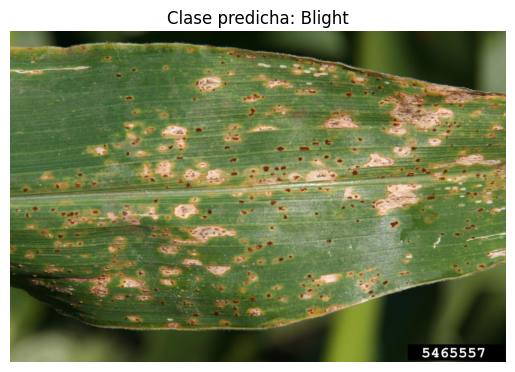

In [10]:
# Mostrar la imagen original redimensionada junto con la clase predicha
imagen_a_analizar = cv2.imread('/kaggle/input/propio/Prueba03.jpg', cv2.IMREAD_COLOR)
plt.title(f"Clase predicha: {nombre_clase_predicha}")
plt.imshow(cv2.cvtColor(imagen_a_analizar, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()